# Compare models — ZINC


In [1]:
import sys
import os
sys.path.insert(0, os.path.abspath('..'))

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import time
import warnings
import hashlib
import json
import os
from pathlib import Path
warnings.filterwarnings('ignore')

from torch_geometric.loader import DataLoader
from tqdm.auto import tqdm

from models import (
    GOAT, Exphormer,    GCN, GAT, GIN, GraphMLP,    GCNVirtualNode, GINVirtualNode)

from src.utils.data import (
    load_zinc_dataset, 
    load_molhiv_dataset, 
    load_molpcba_dataset
)
from src.utils.positional_encodings import precompute_positional_encodings
from src.utils.complexity import ComplexityTracker, count_parameters
from src.utils.metrics import compute_metrics

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")
print(f"PyTorch version: {torch.__version__}")

if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

Device: cuda
PyTorch version: 2.6.0+cu124
GPU: NVIDIA GeForce RTX 3090
GPU Memory: 25.8 GB


## Config


In [2]:

EXPERIMENT_MODE = "gpu"

if EXPERIMENT_MODE == "cpu":
    CONFIG = {
        'dataset': 'zinc',
        'use_subset': True,
        'subset_size': 500,
        'batch_size': 32,
        'num_epochs': 10,
        'hidden_dim': 64,
        'num_layers': 3,
        'num_heads': 4,
        'lr': 1e-3,
        'dropout': 0.1,
        'pe_dim': 8,
        'device': 'cpu',
        'early_stopping': True,
        'patience': 5,
        'min_delta': 1e-5,
        'use_model_specific_lr': True,
        'weight_decay': 1e-5,
        'warmup_epochs': 0,    }
    print("🖥️  TRYB CPU - Szybki test")
else:
    CONFIG = {
        'dataset': 'zinc',
        'use_subset': False,
        'subset_size': None,
        'batch_size': 64,
        'num_epochs': 200,        'hidden_dim': 256,
        'num_layers': 5,
        'num_heads': 8,
        'lr': 1e-4,
        'dropout': 0.1,
        'pe_dim': 16,
        'device': 'cuda' if torch.cuda.is_available() else 'cpu',
        'early_stopping': True,
        'patience': 20,        'min_delta': 1e-4,        'use_model_specific_lr': True,
        'weight_decay': 1e-5,
        'warmup_epochs': 5,    }
    print("🚀 TRYB GPU - Pełny eksperyment")

print(f"\nKonfiguracja:")
for k, v in CONFIG.items():
    print(f"  {k}: {v}")

🚀 TRYB GPU - Pełny eksperyment

Konfiguracja:
  dataset: zinc
  use_subset: False
  subset_size: None
  batch_size: 64
  num_epochs: 200
  hidden_dim: 256
  num_layers: 5
  num_heads: 8
  lr: 0.0001
  dropout: 0.1
  pe_dim: 16
  device: cuda
  early_stopping: True
  patience: 20
  min_delta: 0.0001
  use_model_specific_lr: True
  weight_decay: 1e-05
  warmup_epochs: 5


## Data


In [3]:
def load_dataset_by_name(name, use_subset=False, subset_size=500, pe_dim=8):
    """Załaduj dataset po nazwie."""
    print(f"Ładowanie datasetu: {name}")
    
    if name == 'zinc':
        dataset, split_idx = load_zinc_dataset()
        task_type = 'regression'
        metric = 'mae'
        out_channels = 1
        in_channels = dataset[0].x.shape[1] if dataset[0].x.dim() > 1 else 1
    elif name == 'molhiv':
        dataset, split_idx = load_molhiv_dataset()
        task_type = 'binary_classification'
        metric = 'rocauc'
        out_channels = 1
        in_channels = dataset[0].x.shape[1]
    elif name == 'molpcba':
        dataset, split_idx = load_molpcba_dataset()
        task_type = 'multi_label'
        metric = 'ap'
        out_channels = 128        in_channels = dataset[0].x.shape[1]
    else:
        raise ValueError(f"Nieznany dataset: {name}")
    
    if use_subset:
        print(f"Używam podzbioru: {subset_size} grafów")
        indices = torch.randperm(len(dataset))[:subset_size]
        train_size = int(0.8 * subset_size)
        val_size = int(0.1 * subset_size)
        split_idx = {
            'train': indices[:train_size],
            'valid': indices[train_size:train_size+val_size],
            'test': indices[train_size+val_size:],
        }
    
    print("Obliczam positional encodings...")
    dataset = precompute_positional_encodings(dataset, pe_type='laplacian', pe_dim=pe_dim)
    
    print(f"Dataset załadowany:")
    print(f"  Total: {len(dataset)} grafów")
    print(f"  Train: {len(split_idx['train'])}, Val: {len(split_idx['valid'])}, Test: {len(split_idx['test'])}")
    print(f"  In channels: {in_channels}, Out channels: {out_channels}")
    print(f"  Task type: {task_type}, Metric: {metric}")
    
    return dataset, split_idx, {
        'task_type': task_type,
        'metric': metric,
        'in_channels': in_channels,
        'out_channels': out_channels,
    }

dataset, split_idx, dataset_info = load_dataset_by_name(
    CONFIG['dataset'],
    use_subset=CONFIG['use_subset'],
    subset_size=CONFIG['subset_size'],
    pe_dim=CONFIG['pe_dim'],
)

Ładowanie datasetu: zinc
Obliczam positional encodings...
Setting up laplacian positional encodings (dim=16)...
Precomputing encodings...
  Processed 100/10000 graphs
  Processed 200/10000 graphs
  Processed 300/10000 graphs
  Processed 400/10000 graphs
  Processed 500/10000 graphs
  Processed 600/10000 graphs
  Processed 700/10000 graphs
  Processed 800/10000 graphs
  Processed 900/10000 graphs
  Processed 1000/10000 graphs
  Processed 1100/10000 graphs
  Processed 1200/10000 graphs
  Processed 1300/10000 graphs
  Processed 1400/10000 graphs
  Processed 1500/10000 graphs
  Processed 1600/10000 graphs
  Processed 1700/10000 graphs
  Processed 1800/10000 graphs
  Processed 1900/10000 graphs
  Processed 2000/10000 graphs
  Processed 2100/10000 graphs
  Processed 2200/10000 graphs
  Processed 2300/10000 graphs
  Processed 2400/10000 graphs
  Processed 2500/10000 graphs
  Processed 2600/10000 graphs
  Processed 2700/10000 graphs
  Processed 2800/10000 graphs
  Processed 2900/10000 graphs
 

In [4]:
train_loader = DataLoader(
    dataset[split_idx['train']], 
    batch_size=CONFIG['batch_size'], 
    shuffle=True
)
val_loader = DataLoader(
    dataset[split_idx['valid']], 
    batch_size=CONFIG['batch_size'], 
    shuffle=False
)
test_loader = DataLoader(
    dataset[split_idx['test']], 
    batch_size=CONFIG['batch_size'], 
    shuffle=False
)

print(f"Batchy: Train={len(train_loader)}, Val={len(val_loader)}, Test={len(test_loader)}")

Batchy: Train=125, Val=16, Test=16


## Models


In [5]:
def create_models(config, dataset_info):
    """Stwórz wszystkie modele do porównania."""
    in_ch = dataset_info['in_channels']
    out_ch = dataset_info['out_channels']
    hidden = config['hidden_dim']
    layers = config['num_layers']
    heads = config['num_heads']
    dropout = config['dropout']
    pe_dim = config['pe_dim']
    
    models = {
        'GCN': GCN(
            in_channels=in_ch,
            hidden_channels=hidden,
            out_channels=out_ch,
            num_layers=layers,
            dropout=dropout,
        ),
        'GAT': GAT(
            in_channels=in_ch,
            hidden_channels=hidden,
            out_channels=out_ch,
            num_layers=layers,
            num_heads=heads,
            dropout=dropout,
        ),
        'GIN': GIN(
            in_channels=in_ch,
            hidden_channels=hidden,
            out_channels=out_ch,
            num_layers=layers,
            dropout=dropout,
        ),
        'GraphMLP': GraphMLP(
            in_channels=in_ch,
            hidden_channels=hidden,
            out_channels=out_ch,
            num_layers=layers,
            dropout=dropout,
        ),
        
        'GCN+VN': GCNVirtualNode(
            in_channels=in_ch,
            hidden_channels=hidden,
            out_channels=out_ch,
            num_layers=layers,
            dropout=dropout,
        ),
        'GIN+VN': GINVirtualNode(
            in_channels=in_ch,
            hidden_channels=hidden,
            out_channels=out_ch,
            num_layers=layers,
            dropout=dropout,
        ),
        
        'GOAT': GOAT(
            in_channels=in_ch,
            hidden_channels=hidden,
            out_channels=out_ch,
            num_layers=layers,
            num_heads=heads,
            pe_dim=pe_dim,
            dropout=dropout,
        ),
        'Exphormer': Exphormer(
            in_channels=in_ch,
            hidden_channels=hidden,
            out_channels=out_ch,
            num_layers=layers,
            num_heads=heads,
            pe_dim=pe_dim,
            dropout=dropout,
        ),
    }
    
    return models

models = create_models(CONFIG, dataset_info)

print("\n" + "="*60)
print("MODELE I LICZBA PARAMETRÓW")
print("="*60)
for name, model in models.items():
    params = count_parameters(model)
    print(f"{name:15s}: {params['total']:>10,} parametrów")
print("="*60)


MODELE I LICZBA PARAMETRÓW
GCN            :    332,289 parametrów
GAT            :    334,849 parametrów
GIN            :    925,958 parametrów
GraphMLP       :    263,937 parametrów
GCN+VN         :    928,773 parametrów
GIN+VN         :  1,522,442 parametrów
GOAT           :  5,008,897 parametrów
Exphormer      :  5,337,862 parametrów


## Training


In [6]:
def train_epoch(model, loader, optimizer, device, task_type='regression'):
    """Trenuj przez jedną epokę."""
    model.train()
    total_loss = 0
    
    for batch in loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        
        out = model(batch)
        
        if task_type == 'regression':
            y = batch.y.float().view(-1, 1)
            loss = F.mse_loss(out, y)
        elif task_type == 'binary_classification':
            y = batch.y.float().view(-1, 1)
            loss = F.binary_cross_entropy_with_logits(out, y)
        elif task_type == 'multi_label':
            y = batch.y.float()
            mask = ~torch.isnan(y)
            loss = F.binary_cross_entropy_with_logits(out[mask], y[mask])
        else:
            raise ValueError(f"Unknown task type: {task_type}")
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        
        total_loss += loss.item() * batch.num_graphs
    
    return total_loss / len(loader.dataset)


@torch.no_grad()
def evaluate(model, loader, device, task_type='regression', metric='mae'):
    """Ewaluuj model."""
    model.eval()
    
    all_preds = []
    all_labels = []
    total_loss = 0
    
    for batch in loader:
        batch = batch.to(device)
        out = model(batch)
        
        if task_type == 'regression':
            y = batch.y.float().view(-1, 1)
            loss = F.mse_loss(out, y)
            all_preds.append(out.cpu())
            all_labels.append(y.cpu())
        elif task_type == 'binary_classification':
            y = batch.y.float().view(-1, 1)
            loss = F.binary_cross_entropy_with_logits(out, y)
            all_preds.append(torch.sigmoid(out).cpu())
            all_labels.append(y.cpu())
        elif task_type == 'multi_label':
            y = batch.y.float()
            mask = ~torch.isnan(y)
            loss = F.binary_cross_entropy_with_logits(out[mask], y[mask])
            all_preds.append(torch.sigmoid(out).cpu())
            all_labels.append(y.cpu())
        
        total_loss += loss.item() * batch.num_graphs
    
    all_preds = torch.cat(all_preds, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    
    if metric == 'mae':
        score = F.l1_loss(all_preds, all_labels).item()
    elif metric == 'rocauc':
        from sklearn.metrics import roc_auc_score
        try:
            score = roc_auc_score(all_labels.numpy(), all_preds.numpy())
        except:
            score = 0.5
    elif metric == 'ap':
        from sklearn.metrics import average_precision_score
        mask = ~torch.isnan(all_labels)
        try:
            score = average_precision_score(all_labels[mask].numpy(), all_preds[mask].numpy())
        except:
            score = 0.0
    else:
        score = total_loss / len(loader.dataset)
    
    return score, total_loss / len(loader.dataset)


def get_model_specific_config(model_name, base_config):
    """Zwróć model-specific konfigurację hiperparametrów."""
    config = base_config.copy()
    
    if base_config.get('use_model_specific_lr', False):
        if model_name == 'GOAT':
            config['lr'] = base_config['lr'] * 5.0        elif model_name == 'Exphormer':
            config['lr'] = base_config['lr'] * 3.0        elif model_name in ['GIN', 'GIN+VN']:
            config['lr'] = base_config['lr'] * 10.0        elif model_name in ['GCN+VN']:
            config['lr'] = base_config['lr'] * 10.0    
    config['weight_decay'] = base_config.get('weight_decay', 0.0)
    
    if model_name in ['GOAT', 'Exphormer']:
        config['warmup_epochs'] = base_config.get('warmup_epochs', 0)
    else:
        config['warmup_epochs'] = 0
    
    return config


def get_config_hash(config, model_name, dataset_info):
    """Generate a hash for the configuration to identify checkpoints."""
    model_config = get_model_specific_config(model_name, config)
    
    config_dict = {
        'model_name': model_name,
        'dataset': config.get('dataset', ''),        'batch_size': config.get('batch_size', 0),
        'num_epochs': config.get('num_epochs', 0),
        'hidden_dim': config.get('hidden_dim', 0),
        'num_layers': config.get('num_layers', 0),
        'num_heads': config.get('num_heads', 0),
        'lr': model_config.get('lr', 0),
        'dropout': config.get('dropout', 0),
        'pe_dim': config.get('pe_dim', 0),
        'weight_decay': model_config.get('weight_decay', 0),
        'warmup_epochs': model_config.get('warmup_epochs', 0),
        'early_stopping': config.get('early_stopping', False),
        'patience': config.get('patience', 0),
        'min_delta': config.get('min_delta', 0),
        'task_type': dataset_info.get('task_type', ''),
        'metric': dataset_info.get('metric', ''),
    }
    
    config_str = json.dumps(config_dict, sort_keys=True, default=str)
    return hashlib.md5(config_str.encode()).hexdigest()[:12]


def save_checkpoint(model, optimizer, config_hash, model_name, best_val_score, best_epoch, history, checkpoint_dir='checkpoints'):
    """Save model checkpoint."""
    checkpoint_dir = Path(checkpoint_dir)
    checkpoint_dir.mkdir(exist_ok=True)
    
    checkpoint_path = checkpoint_dir / f"{model_name}_{config_hash}.pt"
    
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'best_val_score': best_val_score,
        'best_epoch': best_epoch,
        'history': history,
        'config_hash': config_hash,
        'model_name': model_name,
    }, checkpoint_path)
    
    return checkpoint_path


def load_checkpoint(model, optimizer, config_hash, model_name, checkpoint_dir='checkpoints', device='cuda'):
    """Load model checkpoint if it exists."""
    checkpoint_dir = Path(checkpoint_dir)
    checkpoint_path = checkpoint_dir / f"{model_name}_{config_hash}.pt"
    
    if not checkpoint_path.exists():
        return None
    
    checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=False)
    
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    
    return {
        'best_val_score': checkpoint['best_val_score'],
        'best_epoch': checkpoint['best_epoch'],
        'history': checkpoint['history'],
    }


def train_model(model, train_loader, val_loader, config, dataset_info, model_name='', verbose=True, checkpoint_dir='checkpoints'):
    """Pełny trening modelu z early stopping i model-specific hyperparameters."""
    device = torch.device(config['device'])
    model = model.to(device)
    
    model_config = get_model_specific_config(model_name, config)
    lr = model_config['lr']
    weight_decay = model_config['weight_decay']
    warmup_epochs = model_config['warmup_epochs']
    
    config_hash = get_config_hash(config, model_name, dataset_info)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    
    checkpoint_data = load_checkpoint(model, optimizer, config_hash, model_name, checkpoint_dir, device)
    if checkpoint_data is not None:
        if verbose:
            print(f"📂 Loaded checkpoint: {model_name} (config hash: {config_hash})")
            print(f"   Best val score: {checkpoint_data['best_val_score']:.4f} at epoch {checkpoint_data['best_epoch']}")
        return {
            'best_val_score': checkpoint_data['best_val_score'],
            'best_epoch': checkpoint_data['best_epoch'],
            'total_epochs': checkpoint_data['best_epoch'],
            'history': checkpoint_data['history'],
            'train_time': 0,            'early_stopped': False,
            'loaded_from_checkpoint': True,
        }
    
    if warmup_epochs > 0:
        def lr_lambda(epoch):
            if epoch < warmup_epochs:
                return (epoch + 1) / warmup_epochs
            else:
                progress = (epoch - warmup_epochs) / (config['num_epochs'] - warmup_epochs)
                return 0.5 * (1 + np.cos(np.pi * progress))
        
        scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)
    else:
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer, T_max=config['num_epochs']
        )
    
    task_type = dataset_info['task_type']
    metric = dataset_info['metric']
    
    higher_is_better = metric in ['rocauc', 'ap', 'accuracy']
    
    best_val_score = float('-inf') if higher_is_better else float('inf')
    history = {'train_loss': [], 'val_score': [], 'lr': []}
    best_model_state = None    
    early_stopping = config.get('early_stopping', False)
    patience = config.get('patience', 20)
    min_delta = config.get('min_delta', 1e-5)
    patience_counter = 0
    best_epoch = 0
    
    start_time = time.time()
    
    pbar = tqdm(range(config['num_epochs']), disable=not verbose)
    for epoch in pbar:
        train_loss = train_epoch(model, train_loader, optimizer, device, task_type)
        val_score, val_loss = evaluate(model, val_loader, device, task_type, metric)
        
        current_lr = optimizer.param_groups[0]['lr']
        scheduler.step()
        
        history['train_loss'].append(train_loss)
        history['val_score'].append(val_score)
        history['lr'].append(current_lr)
        
        improved = False
        if higher_is_better:
            if val_score > best_val_score + min_delta:
                best_val_score = val_score
                best_epoch = epoch
                improved = True
                patience_counter = 0
                best_model_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        else:
            if val_score < best_val_score - min_delta:
                best_val_score = val_score
                best_epoch = epoch
                improved = True
                patience_counter = 0
                best_model_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        
        if not improved:
            patience_counter += 1
        
        if early_stopping and patience_counter >= patience:
            if verbose:
                pbar.write(f"⏹️  Early stopping at epoch {epoch+1} (no improvement for {patience} epochs)")
                pbar.write(f"   Best score: {best_val_score:.4f} at epoch {best_epoch+1}")
            break
        
        pbar.set_postfix({
            'loss': f'{train_loss:.4f}',
            f'val_{metric}': f'{val_score:.4f}',
            f'best': f'{best_val_score:.4f}',
            'patience': f'{patience_counter}/{patience}',
            'lr': f'{current_lr:.2e}'
        })
    
    train_time = time.time() - start_time
    
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        model = model.to(device)
    
    checkpoint_path = save_checkpoint(
        model, optimizer, config_hash, model_name, 
        best_val_score, best_epoch + 1, history, checkpoint_dir
    )
    if verbose:
        print(f"💾 Checkpoint saved: {checkpoint_path}")
    
    return {
        'best_val_score': best_val_score,
        'best_epoch': best_epoch + 1,
        'total_epochs': epoch + 1,
        'history': history,
        'train_time': train_time,
        'early_stopped': early_stopping and patience_counter >= patience,
        'loaded_from_checkpoint': False,
        'checkpoint_path': str(checkpoint_path),
    }

## Trening wszystkich modeli

In [7]:
results = {}

print("="*70)
print("TRENING WSZYSTKICH MODELI")
print("="*70)

for name, model in models.items():
    print(f"\n{'='*70}")
    print(f"Trenuję: {name}")
    print(f"{'='*70}")
    
    for layer in model.modules():
        if hasattr(layer, 'reset_parameters'):
            layer.reset_parameters()
    
    if torch.cuda.is_available() and CONFIG['device'] == 'cuda':
        torch.cuda.reset_peak_memory_stats()
    
    result = train_model(
        model, 
        train_loader, 
        val_loader, 
        CONFIG, 
        dataset_info,
        model_name=name,        verbose=True,
        checkpoint_dir='checkpoints'    )
    
    result['params'] = count_parameters(model)['total']
    if torch.cuda.is_available() and CONFIG['device'] == 'cuda':
        result['peak_memory_mb'] = torch.cuda.max_memory_allocated() / 1e6
    else:
        result['peak_memory_mb'] = 0
    
    results[name] = result
    
    early_stop_info = f" (early stopped at epoch {result.get('total_epochs', '?')})" if result.get('early_stopped', False) else ""
    checkpoint_info = " [LOADED FROM CHECKPOINT]" if result.get('loaded_from_checkpoint', False) else ""
    print(f"\n✓ {name}: Best val {dataset_info['metric']} = {result['best_val_score']:.4f} at epoch {result.get('best_epoch', '?')}{early_stop_info}{checkpoint_info}")
    if not result.get('loaded_from_checkpoint', False):
        print(f"  Czas: {result['train_time']:.1f}s, Parametry: {result['params']:,}")
    else:
        print(f"  Parametry: {result['params']:,} (skipped training - loaded from checkpoint)")

print("\n" + "="*70)
print("TRENING ZAKOŃCZONY")
print("="*70)

TRENING WSZYSTKICH MODELI

Trenuję: GCN


  0%|          | 0/200 [00:00<?, ?it/s]

⏹️  Early stopping at epoch 136 (no improvement for 20 epochs)
   Best score: 0.8289 at epoch 116
💾 Checkpoint saved: checkpoints\GCN_6ec8d0da3021.pt

✓ GCN: Best val mae = 0.8289 at epoch 116 (early stopped at epoch 136)
  Czas: 150.9s, Parametry: 332,289

Trenuję: GAT


  0%|          | 0/200 [00:00<?, ?it/s]

⏹️  Early stopping at epoch 92 (no improvement for 20 epochs)
   Best score: 0.6927 at epoch 72
💾 Checkpoint saved: checkpoints\GAT_c3b433ce0d4e.pt

✓ GAT: Best val mae = 0.6927 at epoch 72 (early stopped at epoch 92)
  Czas: 162.5s, Parametry: 334,849

Trenuję: GIN


  0%|          | 0/200 [00:00<?, ?it/s]

💾 Checkpoint saved: checkpoints\GIN_ef1585522884.pt

✓ GIN: Best val mae = 0.3681 at epoch 189
  Czas: 339.8s, Parametry: 925,958

Trenuję: GraphMLP


  0%|          | 0/200 [00:00<?, ?it/s]

⏹️  Early stopping at epoch 141 (no improvement for 20 epochs)
   Best score: 0.8312 at epoch 121
💾 Checkpoint saved: checkpoints\GraphMLP_6d849501b94c.pt

✓ GraphMLP: Best val mae = 0.8312 at epoch 121 (early stopped at epoch 141)
  Czas: 117.8s, Parametry: 263,937

Trenuję: GCN+VN


  0%|          | 0/200 [00:00<?, ?it/s]

⏹️  Early stopping at epoch 198 (no improvement for 20 epochs)
   Best score: 0.4746 at epoch 178
💾 Checkpoint saved: checkpoints\GCN+VN_f9bc1dd423f5.pt

✓ GCN+VN: Best val mae = 0.4746 at epoch 178 (early stopped at epoch 198)
  Czas: 579.9s, Parametry: 928,773

Trenuję: GIN+VN


  0%|          | 0/200 [00:00<?, ?it/s]

💾 Checkpoint saved: checkpoints\GIN+VN_07898fd40d40.pt

✓ GIN+VN: Best val mae = 0.3550 at epoch 199
  Czas: 559.7s, Parametry: 1,522,442

Trenuję: GOAT


  0%|          | 0/200 [00:00<?, ?it/s]

⏹️  Early stopping at epoch 140 (no improvement for 20 epochs)
   Best score: 0.5304 at epoch 120
💾 Checkpoint saved: checkpoints\GOAT_85d9bc7025a0.pt

✓ GOAT: Best val mae = 0.5304 at epoch 120 (early stopped at epoch 140)
  Czas: 5603.1s, Parametry: 5,008,897

Trenuję: Exphormer


  0%|          | 0/200 [00:00<?, ?it/s]

⏹️  Early stopping at epoch 80 (no improvement for 20 epochs)
   Best score: 0.6515 at epoch 60
💾 Checkpoint saved: checkpoints\Exphormer_6e8ba1460d9f.pt

✓ Exphormer: Best val mae = 0.6515 at epoch 60 (early stopped at epoch 80)
  Czas: 1333.5s, Parametry: 5,337,862

TRENING ZAKOŃCZONY


## Podsumowanie wyników

In [8]:
import pandas as pd

metric = dataset_info['metric']
higher_is_better = metric in ['rocauc', 'ap', 'accuracy']

summary = []
for name, res in results.items():
    summary.append({
        'Model': name,
        f'Val {metric.upper()}': res['best_val_score'],
        'Parametry': res['params'],
        'Czas (s)': res['train_time'],
        'Pamięć (MB)': res['peak_memory_mb'],
    })

df = pd.DataFrame(summary)

df = df.sort_values(f'Val {metric.upper()}', ascending=not higher_is_better)

print("\n" + "="*80)
print(f"PODSUMOWANIE WYNIKÓW - Dataset: {CONFIG['dataset'].upper()}")
print("="*80)
print(df.to_string(index=False))
print("="*80)


PODSUMOWANIE WYNIKÓW - Dataset: ZINC
    Model  Val MAE  Parametry    Czas (s)  Pamięć (MB)
   GIN+VN 0.354960    1522442  559.665595   128.762368
      GIN 0.368124     925958  339.805760    98.410496
   GCN+VN 0.474645     928773  579.891866    86.090240
     GOAT 0.530429    5008897 5603.137498   309.679104
Exphormer 0.651451    5337862 1333.504113   571.068928
      GAT 0.692696     334849  162.520065   102.077952
      GCN 0.828897     332289  150.944782    58.889216
 GraphMLP 0.831242     263937  117.821474    59.516416


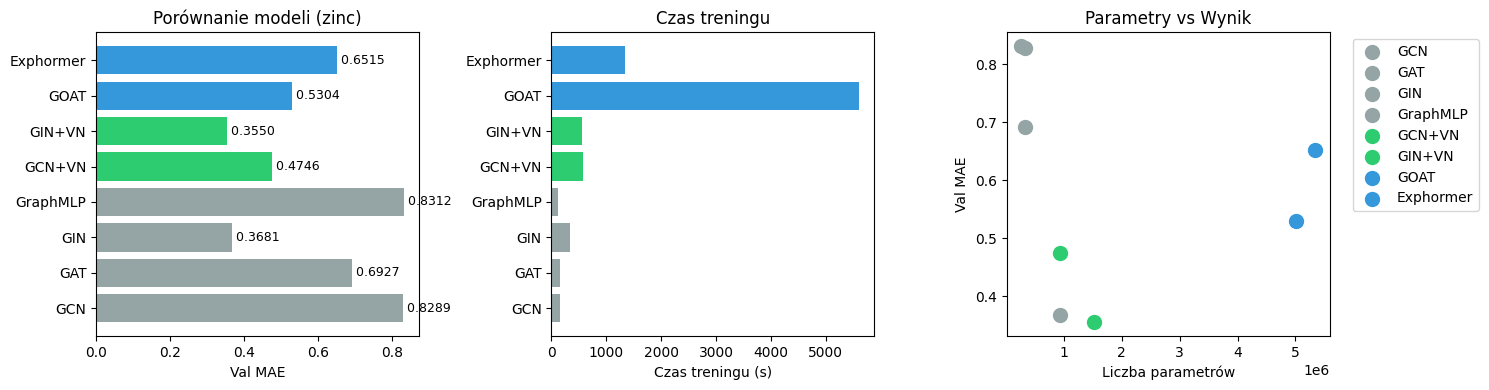


Wykres zapisany: model_comparison.png


In [9]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

ax = axes[0]
names = list(results.keys())
scores = [results[n]['best_val_score'] for n in names]
colors = ['#2ecc71' if 'VN' in n else '#3498db' if n in ['GOAT', 'Exphormer'] else '#95a5a6' for n in names]
bars = ax.barh(names, scores, color=colors)
ax.set_xlabel(f'Val {metric.upper()}')
ax.set_title(f'Porównanie modeli ({CONFIG["dataset"]})')
for bar, score in zip(bars, scores):
    ax.text(bar.get_width(), bar.get_y() + bar.get_height()/2, 
            f' {score:.4f}', va='center', fontsize=9)

ax = axes[1]
times = [results[n]['train_time'] for n in names]
ax.barh(names, times, color=colors)
ax.set_xlabel('Czas treningu (s)')
ax.set_title('Czas treningu')

ax = axes[2]
params = [results[n]['params'] for n in names]
for i, name in enumerate(names):
    ax.scatter(params[i], scores[i], s=100, c=colors[i], label=name)
ax.set_xlabel('Liczba parametrów')
ax.set_ylabel(f'Val {metric.upper()}')
ax.set_title('Parametry vs Wynik')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nWykres zapisany: model_comparison.png")

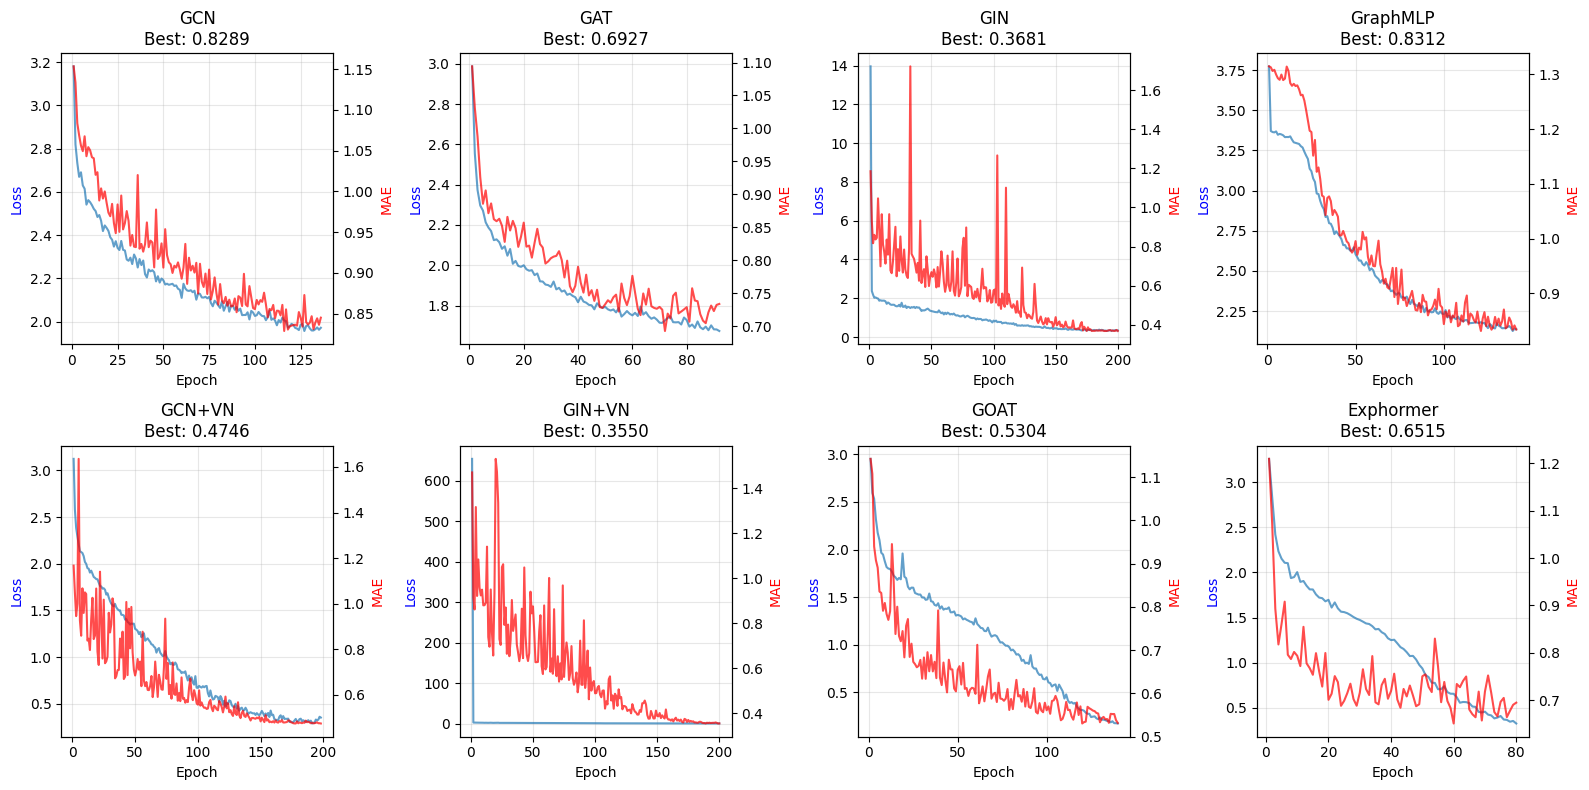


Wykres zapisany: learning_curves.png


In [10]:
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for idx, (name, res) in enumerate(results.items()):
    if idx >= len(axes):
        break
    ax = axes[idx]
    epochs = range(1, len(res['history']['train_loss']) + 1)
    
    ax.plot(epochs, res['history']['train_loss'], label='Train Loss', alpha=0.7)
    ax2 = ax.twinx()
    ax2.plot(epochs, res['history']['val_score'], 'r-', label=f'Val {metric}', alpha=0.7)
    
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss', color='b')
    ax2.set_ylabel(f'{metric.upper()}', color='r')
    ax.set_title(f'{name}\nBest: {res["best_val_score"]:.4f}')
    ax.grid(True, alpha=0.3)

for idx in range(len(results), len(axes)):
    axes[idx].set_visible(False)

plt.tight_layout()
plt.savefig('learning_curves.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nWykres zapisany: learning_curves.png")

## Wnioski

Po uruchomieniu eksperymentu, wypełnij wnioski:

1. **Najlepszy model:** `[TUTAJ]`
2. **Czy modele hybrydowe (VN) poprawiają wyniki?** `[TAK/NIE]`
3. **Czy Graph Transformers są lepsze od GNN?** `[TAK/NIE/ZALEŻY]`
4. **Trade-off czas/jakość:** `[OPIS]`

In [11]:
import json

save_results = {}
for name, res in results.items():
    save_results[name] = {
        'best_val_score': float(res['best_val_score']),
        'params': res['params'],
        'train_time': res['train_time'],
        'peak_memory_mb': res['peak_memory_mb'],
    }

output = {
    'config': CONFIG,
    'dataset_info': dataset_info,
    'results': save_results,
}

filename = f"results_{CONFIG['dataset']}_{EXPERIMENT_MODE}.json"
with open(filename, 'w') as f:
    json.dump(output, f, indent=2)

print(f"Wyniki zapisane do: {filename}")

Wyniki zapisane do: results_zinc_gpu.json
